# AR-MA



## Обзор

В этой лекции мы рассмотрим:
- Автокорреляционную функцию (АКФ).
- Частичную автокорреляционную функцию (ЧАКФ).
- Объяснение того, как работают модели авторегрессии и скользящего среднего.

In [1]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
np.random.seed(0) # For reproducibility

def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

## Корреляции во временных рядах
- Корреляционная функция измеряет степень связи между двумя случайными величинами.
- В данных временных рядов она измеряет связь между двумя различными точками во времени.
- Корреляция необходима для понимания линейной связи и зависимости в данных временных рядов.
- Существует два типа корреляционных функций:
  - Автокорреляция.
  - Кросс-корреляция.

### Функция автокорреляции (ACF)
- ACF измеряет корреляцию временного ряда с его собственными запаздывающими значениями
  
  $$ ACF(k) = \frac{\mathbb{E}[(X(t) - \mu)(X(t-k) - \mu)]}{\sigma^2} $$
  
  где:
  - $k$ - число лага.
  - $X(t)$ - значение в момент времени $t$.
  - $\mu$ - среднее значение ряда.
  - $\sigma^2$ - дисперсия ряда.
- Значения, близкие к 1 или -1, указывают на сильную корреляцию, тогда как значения, близкие к 0, указывают на слабую корреляцию.

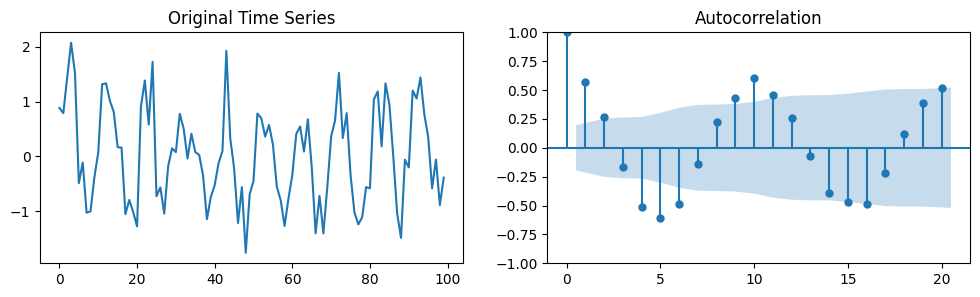

In [2]:
n = 100
time_series_1 = np.random.normal(0, 0.5, n) + np.sin(2*np.pi/10*np.arange(n))
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(time_series_1)
axes[0].set_title('Original Time Series')
plot_acf(time_series_1, lags=20, alpha=0.05, ax=axes[1]); # We plot the first 20 lags. We could plot more by changing the `lags` argument.

- Стебли представляют собой запаздывающие значения корреляции.
- Временной ряд хорошо коррелирует с самим собой, смещенным на 1 (запаздывание 1).
- Запаздывание 2 коррелирует почти, но не совсем так же хорошо. И так далее.

- Синяя область представляет собой доверительный интервал.
- Корреляции за пределами доверительного интервала статистически значимы, тогда как остальные - нет.
- $\alpha$ в этом случае был равен 0,05 (95% доверительный интервал), но его можно установить на других уровнях.
- Более подробную информацию см. в [документации](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html).

### Функция взаимной корреляции (CCF)

- CCF измеряет корреляцию между двумя временными рядами с разными лагами:

$$CCF(k) = \frac{E[(X(t) - \mu_x)(Y(t-k) - \mu_y)]}{\sigma_x \sigma_y}$$

- где:
  - $X$ и $Y$ - два разных временных ряда.
  - $\mu_x, \mu_y$ - их средние значения, а $\sigma_x, \sigma_y$ - их стандартные отклонения.
- CCF обычно используется для поиска более короткой известной функции в длинном сигнале.

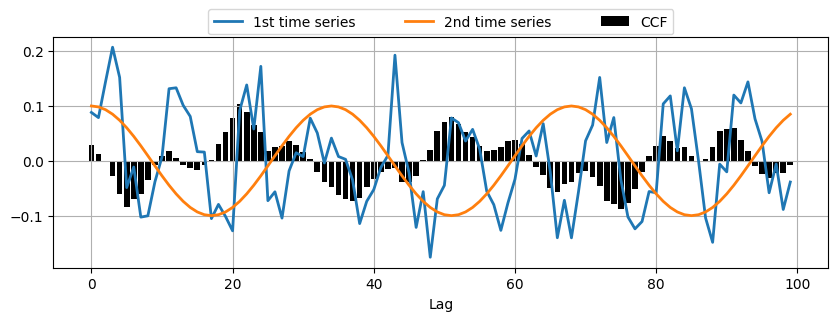

In [3]:
time_series_2 = np.cos(np.pi/17*np.arange(n))

# Calculate CCF between the two time series
ccf_vals = ccf(time_series_1, time_series_2, adjusted=False)

# Plot CCF
_, ax = plt.subplots(1,1,figsize=(10,3))
ax.bar(range(len(ccf_vals)), ccf_vals, color='k', label='CCF')
ax.plot(time_series_1*0.1, linewidth=2, label='1st time series')
ax.plot(time_series_2*0.1, linewidth=2, label='2nd time series')
plt.xlabel('Lag')
plt.legend(bbox_to_anchor=(0.2, 1.01, .6, 1.5), loc='lower center', ncol=3, mode="expand", borderaxespad=0.)
plt.grid();

### Практическое применение корреляционных функций
- Определение характера данных (например, случайны ли они, имеют ли тенденцию или сезонность).
- Помощь в определении порядка моделей ARIMA (подробнее об этом позже).
- Выявление выбросов в данных временных рядов.

### Ограничения и соображения
1. Корреляционные функции измеряют только *линейные* отношения.
2. Для получения значимых результатов временные ряды должны быть *стационарными*.
3. Высокая корреляция не подразумевает *причинно-следственную связь* и иногда может вводить в заблуждение.


4. ACF измеряет как прямые, так и *косвенные корреляции* между лагами.

- Сильная корреляция при более высоких лагах может быть результатом накопления корреляций при более коротких лагах.

- Рассмотрим, например, случайное блуждание:

$$X(t)=X(t-1)+\epsilon_t$$

- Вы можете подумать, что важен только лаг $h=1$, но...

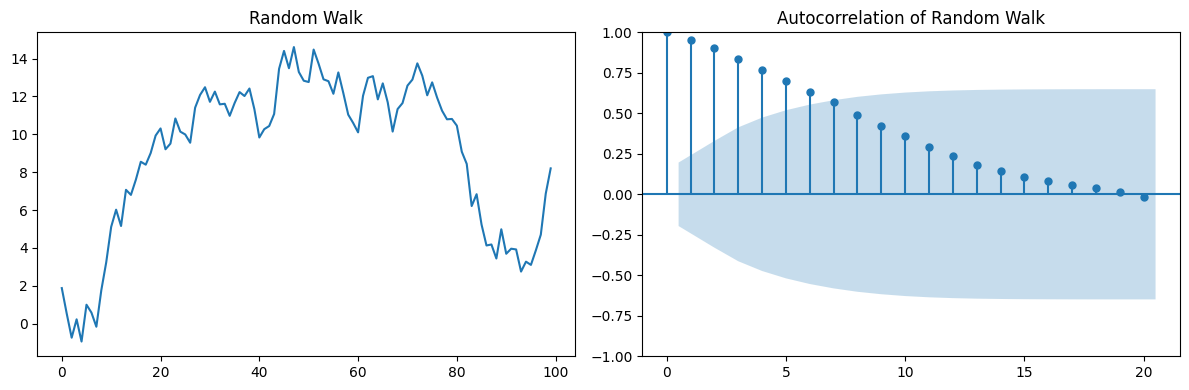

In [4]:
random_walk = np.cumsum(np.random.normal(0, 1, 100))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(random_walk)
axes[0].set_title('Random Walk')
plot_acf(random_walk, lags=20, alpha=0.05, ax=axes[1])
axes[1].set_title('Autocorrelation of Random Walk')
plt.tight_layout()

- Вы можете видеть, что лаги $h>1$ также присутствуют в ACF.
- Это косвенные корреляции из-за накопления основной корреляции при лаге $h=1$.

### Частичная автокорреляционная функция (PACF)

- PACF устраняет 4-е ограничение ACF, изолируя прямую корреляцию между временным рядом и его версией с запаздыванием.
- Это достигается путем устранения влияния корреляций при более коротких запаздываниях.
- Высокий PACF при запаздывании $k$ указывает на сильную частичную корреляцию с $k$-м запаздыванием, не учитываемую корреляциями при более коротких запаздываниях.

- PACF лага $k$ иногда обозначается как $\phi_{kk}$:

$$\phi_{kk} = \text{Corr}\big(X(t) - \hat{X}(t), X(t-k) - \hat{X}(t-k)\big)$$

- где:
    - $\hat{X}(t)$ - это прогнозируемое значение $X(t)$ на основе всех значений до $t-1$.
    - $\hat{X}(t-k)$ - это прогнозируемое значение $X(t-k)$ на основе всех значений до $t-k-1$.

- Совместное использование ACF и PACF обеспечивает более полное понимание данных временного ряда.
- ACF помогает определить общую структуру корреляции и потенциальную сезонность.
- PACF выявляет конкретные лаги, которые оказывают существенное прямое влияние на текущее значение.

**Пример**

- Рассмотрим временной ряд, где ACF показывает значительную корреляцию на лагах 1, 2 и 3.
- Без PACF неясно, является ли корреляция на лаге 3 прямой или просто отражением сильных корреляций на лагах 1 и 2.
- PACF может прояснить это, показав, есть ли значимая прямая корреляция на лаге 3.

In [5]:
n = 100
time_series = np.zeros(n)
alpha1, alpha2, alpha3 = 0.6, -0.3, 0.2  # Coefficients to induce autocorrelation at lags 1, 2, and 3
noise = np.random.normal(0, 1, n)

# Generate correlated data
for t in range(3, n):
    time_series[t] = alpha1 * time_series[t-1] + alpha2 * time_series[t-2] + alpha3 * time_series[t-3] + noise[t]

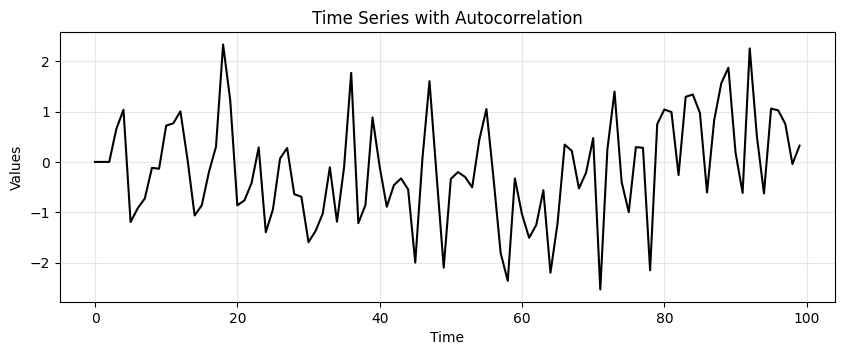

In [6]:
run_sequence_plot(np.arange(100), time_series, title='Time Series with Autocorrelation');

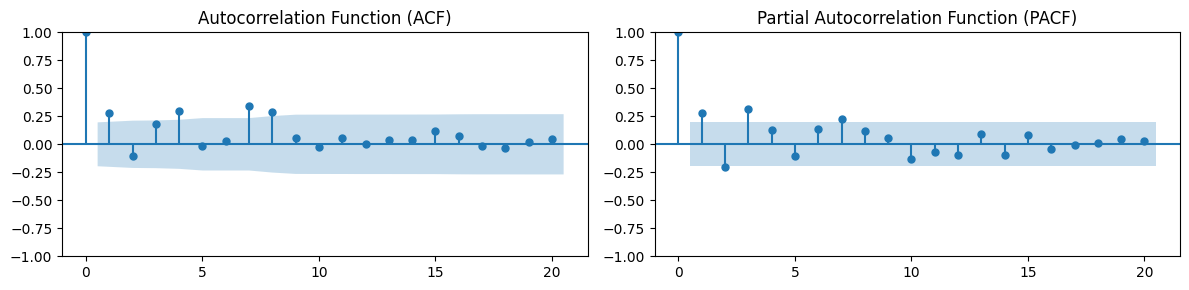

In [7]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot ACF
plot_acf(time_series, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(time_series, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

- Оценка задержки с помощью ACF и PACF полезна при моделировании временных рядов с помощью моделей авторегрессии и скользящего среднего, которые мы представим в следующих разделах.

## Autoregressive (AR) models

- Авторегрессионная (AR) модель - это тип модели временного ряда, которая использует наблюдения из предыдущих временных шагов в качестве входных данных для уравнения регрессии для прогнозирования значения на следующем временном шаге.
- AR-модель зависит исключительно от своих собственных прошлых значений.
  

- Общая форма AR-модели порядка $p$ имеет вид:

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \dots + \phi_p X(t-p) + \epsilon_t$$

- where
    - $X(t)$: Time series value at time $t$.
    - $c$: Constant term (also known as the intercept).
    - $\phi_1, \phi_2, \dots, \phi_p$: Coefficients of the model.
    - $p$: Order of the AR model (number of lag terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

**Модель AR(1)**

- Модель авторегрессии первого рода, AR(1), это

$$X(t) = c + \phi_1 X(t-1) + \epsilon_t$$

- В модели AR(1) текущее значение основано на непосредственно предшествующем значении.

> Пример: простая модель цены акций, в которой сегодняшняя цена частично зависит от вчерашней цены.

**Модели AR более высокого порядка**
- Модели AR более высокого порядка (AR(2), AR(3) и т. д.) зависят от более чем одного прошлого значения.
- Например, модель AR(2) выглядит следующим образом:

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \epsilon_t$$

- Эти модели полезны в сценариях, где влияние более чем одного предыдущего временного шага является значительным.

**Оценка коэффициентов модели AR**
- Коэффициенты моделей AR можно оценить с помощью различных методов, таких как оценка максимального правдоподобия или оценка наименьших квадратов.
- Оцененные коэффициенты дают представление о влиянии прошлых значений на текущее значение во временном ряду.
- Другими словами, модели AR *интерпретируемы*.

**Ограничения моделей AR**
- Модели AR требуют, чтобы временные ряды были *стационарными*.
- Модели AR более высокого порядка могут *переобучать* обучающие данные и плохо выполнять прогнозирование.
- Они не могут моделировать нелинейные зависимости в данных.

- Изначально модели AR не учитывают *экзогенные факторы*.
- Обычно это дополнительные временные ряды, которые важны для прогнозирования.
- Например, временные ряды температур при прогнозировании электрической нагрузки.
- Существуют расширения (ARMAX), которые позволяют включать экзогенные переменные в модель.

### Идентификация модели AR

- Как определить правильный порядок $p$ модели AR?
- Мы делаем это, просматривая первые лаги PACF.
- Давайте рассмотрим это на примере.

- Мы генерируем некоторые данные из процесса AR(2) с коэффициентами `[1.0, -0.5, 0.7]`.
- Обратите внимание, что `1.0` в начале относится к нулевой задержке и всегда равно `1.0`.

In [8]:
ar_data = arma_generate_sample(ar=np.array([1.0, -0.5, 0.7]), ma=np.array([1]), nsample=200, scale=1, burnin=1000)

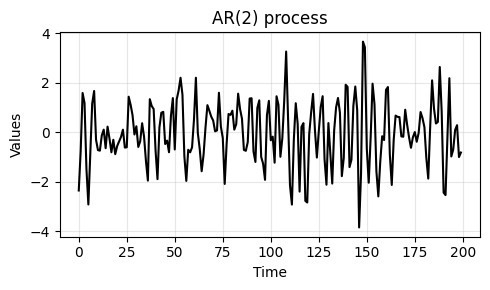

In [9]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
run_sequence_plot(np.arange(200), ar_data, ax=ax, title="AR(2) process")
plt.tight_layout()

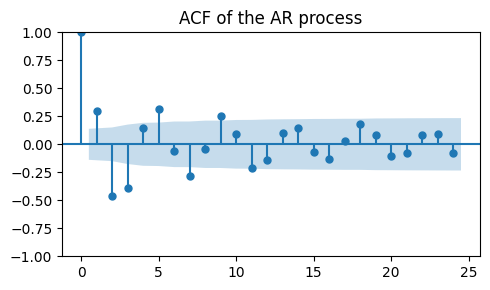

In [10]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ar_data, ax=ax, title="ACF of the AR process")
plt.tight_layout();

- Далее мы вычисляем PACF для `ar_data`.

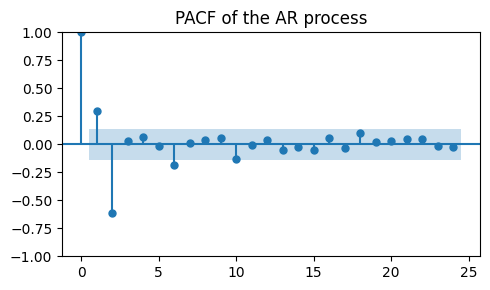

In [11]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(ar_data, ax=ax, title="PACF of the AR process")
plt.tight_layout();

- Помимо пика на лаге 0, который всегда есть, мы видим два существенных запаздывания:
    - *Положительный* пик на лаге 1, введенный *отрицательным* коэффициентом `0,5`.
    - *Отрицательный* пик на лаге 2, введенный *положительным* коэффициентом `0,7`.

- Это означает, что процесс имеет *память* длиной 2.
- Другими словами, (большинство) корреляций в данных объясняются предыдущими 2 временными шагами.
- Если мы хотим подогнать модель AR к нашим данным, мы выберем $p=2$, что является моделью AR(2).

- Наконец, процесс AR характеризуется корреляциями, которые медленно затухают со временем.
- Это можно увидеть, посмотрев на график ACF, где мы видим значительные всплески на протяжении многих задержек.

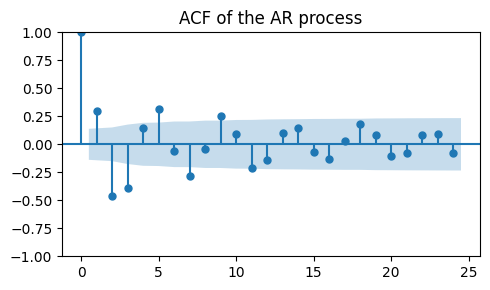

In [12]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ar_data, ax=ax, title="ACF of the AR process")
plt.tight_layout()

**⚙ Попробуйте сами**

- Попробуйте изменить/добавить/удалить значения в коэффициентах `ar` в `arma_generate_sample`.
- Затем посмотрите, как изменится график PACF.

### Прогнозирование с помощью моделей AR

- Как мы вычисляем прогнозы с помощью модели AR?
- В общем, наш временной ряд имеет тренд и сезонность.
- Однако модель AR можно использовать только на *стационарных* данных.
- Поэтому нам нужно выполнить следующие шаги.

#### Шаг 1: Удалить тренд и сезонность
- Перед применением модели AR необходимо сделать временной ряд стационарным.
- Это можно сделать с помощью методов, которые мы видели в предыдущих главах.
- Есть два возможных способа сделать это:
1. Применить стандартную и сезонную дифференциацию к временному ряду.

$$
\begin{aligned}
R'(t) = X(t + 1) - X(t) & \qquad \text{удаляет тренд} \\
R(t) = R'(t + L) - R'(t) & \qquad \text{удаляет сезонность}
\end{aligned}
$$

2. Оценить тренд $T$ и сезонность $S$ (например, с помощью сезонной декомпозиции или методов сглаживания) и вычесть их:

$$R(t) = X(t) - T(t) - S(t)$$

#### Шаг 2: Применение модели AR

- Определите порядок модели AR.
- Подгоните модель AR к временному ряду $R(t)$ с исключенными трендами и сезонными колебаниями.
- Используйте модель для прогнозирования следующих значений $\hat R(t+\tau), \tau=1, \dots, H$, где $H$ — это горизонт прогнозирования.

#### Шаг 3: Реконструируйте прогноз

- Процедура реконструкции зависит от того, как мы сделали временной ряд стационарным на шаге 1.
- Если мы использовали дифференциацию:
- Мы должны отменить дифференциацию, взяв кумулятивные суммы остатков.
- Если мы смоделировали и удалили тренд и сезонность, для каждого $\tau \in [1, H]$:
- Предскажите тренд $\hat{T}(t+\tau)$ и сезонную составляющую $\hat{S}(t+\tau)$.
- Добавьте обратно предполагаемый тренд и сезонность к прогнозируемому значению:

$$\hat X(t+\tau) = \hat R(t+\tau) + \hat{T}(t+\tau) + \hat{S}(t+\tau)$$

### Пример: прогнозирование с помощью модели дополненной реальности

- Давайте сгенерируем некоторые данные с трендом и сезонностью.

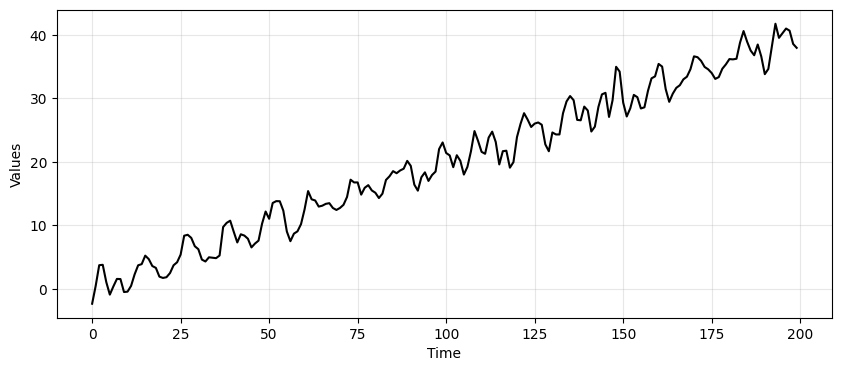

In [13]:
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12) # Seasonality 12
time_series_ar = trend + seasonality + ar_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ar, "", ax=ax);

- Поскольку мы собираемся вычислять прогнозы, давайте разделим данные на обучающий и тестовый наборы.

In [14]:
train_data_ar = time_series_ar[:164]
test_data_ar = time_series_ar[164:]

- Чтобы определить порядок $p$ модели AR, нам нужно посмотреть на PACF.
- Порядок $p$ соответствует наименьшему ненулевому запаздыванию на графике PACF.

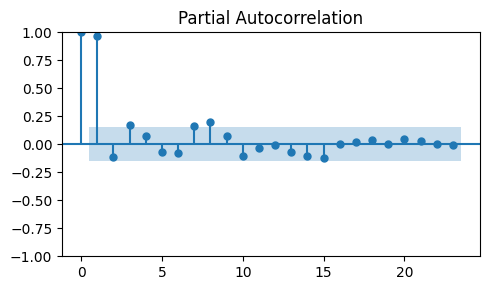

In [15]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(train_data_ar, ax=ax)
plt.tight_layout();

- PACF предполагает порядок $p=1$.
- Однако эта PACF *не имеет особого смысла*.
- Как мы уже обсуждали, и ACF, и PACF следует вычислять на стационарных данных.
- Если данные стационарны, корреляции быстро падают.
- Если нет, это признак того, что ваши данные не стационарны.

- Поскольку мы сгенерировали временной ряд вручную, мы знаем, что он имеет тренд и сезонность, и, следовательно, он не является стационарным.
- Однако, чтобы быть строгими, мы проверим временной ряд с помощью расширенного теста Дики-Фуллера (ADF).

In [16]:
_, pvalue, _, _, _, _ = adfuller(train_data_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.833


- Такое высокое значение p означает, что мы *не* можем отвергнуть нулевую гипотезу

$$H_0: \text{данные нестационарны}$$

- Здесь нет никаких сюрпризов.

- Чтобы добиться стационарности, мы можем преобразовать данные, применив один из методов, обсуждаемых в [шаге 1](#step-1-remove-trend-and-seasonality).
- Давайте сначала попробуем с дифференцированием.

#### Стационарность через дифференциацию

- Начнем с применения дифференциации 1-го порядка для удаления тренда.
- Затем проверим стационарность разностных данных с помощью теста ADF.

In [17]:
diff_ar = train_data_ar[1:] - train_data_ar[:-1]

_, pvalue, _, _, _, _ = adfuller(diff_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.000


- Тест ADF предполагает, что теперь временной ряд стационарен.
- Мы можем также применить *сезонную дифференциацию*, чтобы избавиться от сезонной составляющей.
- Однако слишком частое дифференцирование может нарушить структуру данных.
- Эта проблема называется *чрезмерной дифференциацией*.
- См. [это объяснение](https://people.duke.edu/~rnau/411arim2.htm) для определения оптимального порядка дифференциации.

- Давайте посмотрим, как будут выглядеть данные после взятия производной 1-го порядка.

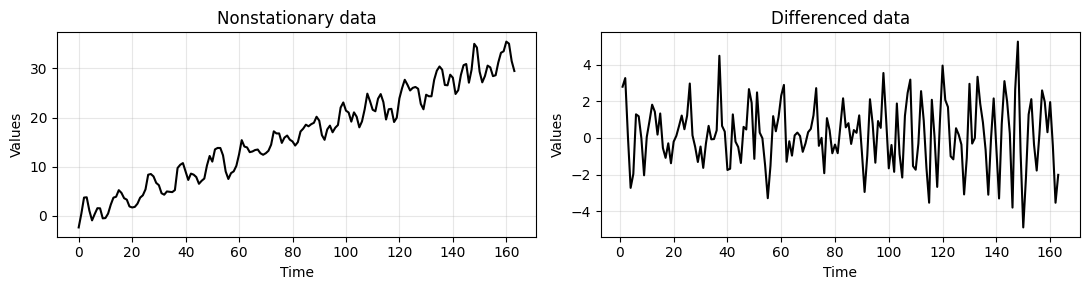

In [18]:
_, axes = plt.subplots(1,2, figsize=(11,3))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, title="Nonstationary data", ax=axes[0])
run_sequence_plot(time[1:len(train_data_ar)], diff_ar, title="Differenced data", ax=axes[1])
plt.tight_layout();

- Давайте пересчитаем PACF на разностных данных.
- Мы также сравним его с PACF на исходных `ar_data` и нестационарных данных `train_data_ar`.

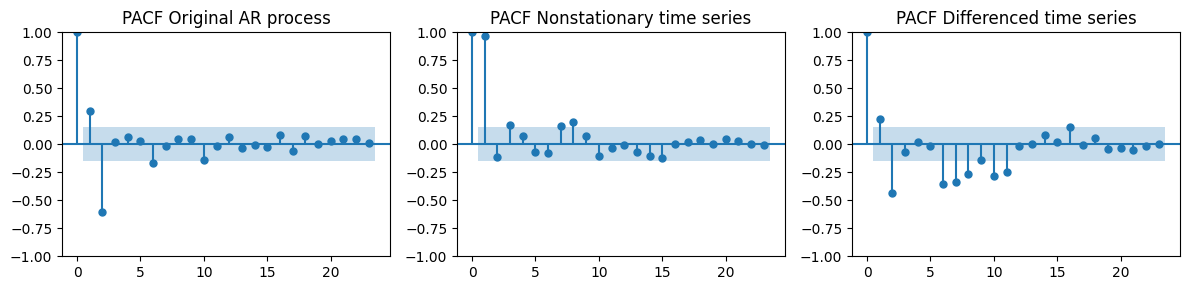

In [19]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(train_data_ar, ax=axes[1], title="PACF Nonstationary time series")
plot_pacf(diff_ar, ax=axes[2], title="PACF Differenced time series")
plt.tight_layout();

- Выраженный отрицательный пик на лаге 2 появляется как в PACF исходных данных AR, так и в разностном временном ряду.
- Эти два выглядят гораздо более похожими, чем PACF, который мы получили для нестационарных данных.
- Выраженный пик на лаге 2 предполагает, что $p=2$, т. е. нам следует использовать модель AR(2).

**⚠ Внимание**

- В разностном временном ряду есть и другие значительные пики при более высоких задержках, которых нет в исходных данных AR.
- Это связано с тем, что в данных остался сезонный компонент.
- Давайте посмотрим, сможем ли мы удалить их, применив сезонную разность и пересчитав график PACF.

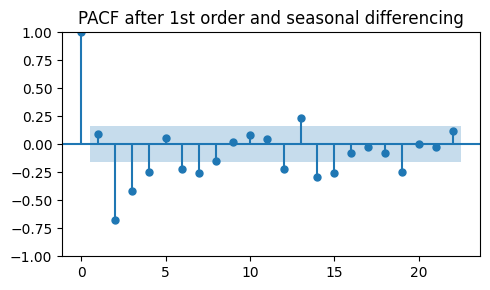

In [20]:
# Seasonal differencing
diff_diff_ar = diff_ar[12:] - diff_ar[:-12]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(diff_diff_ar, ax=ax, title="PACF after 1st order and seasonal differencing")
plt.tight_layout();

- Даже после сезонного дифференцирования мы не можем восстановить PACF исходных данных.
- Напротив, этот PACF выглядит еще более отличным от исходного.
- На практике редко удается получить «чистый» PACF только с одним заметным лагом в правильном порядке при использовании дифференцирования.
- Интерпретация графиков PACF (и ACF) для выбора порядка модели требует навыков и опыта.
- См. [это объяснение](https://people.duke.edu/~rnau/411arim3.htm) для выбора порядка моделей AR и MA.

**📝 Примечание**

- Помимо чрезмерной дифференциации, возникают и другие проблемы, когда стационарность достигается с помощью дифференциации.
- Некоторые данные теряются в начале или в конце временного ряда из-за дифференциации.
- Например, при применении 1-го порядка и сезонной дифференциации теряются шаги $L+1$.
- Кроме того, легко ошибиться при отмене дифференциации для составления прогнозов.
- Это еще больше усложняет ситуацию, когда между обучающим и тестовым наборами есть разрыв или когда горизонт прогнозирования $H$ выходит за пределы сезонности $L$.

#### Стационарность путем вычитания предполагаемого тренда и сезонности

- Мы могли бы оценить тренд и сезонность с помощью тройного экспоненциального сглаживания (TES).
- Затем мы вычисляем остатки, вычитая предполагаемый тренд и сезонность.
- Мы видим, что в этом случае остатки гораздо ближе к нашему исходному процессу AR.

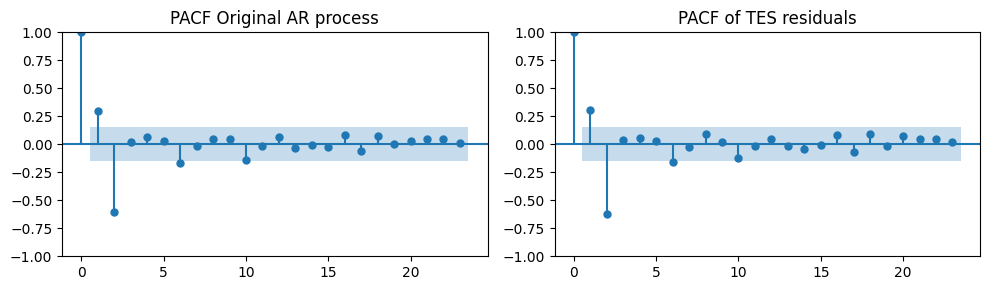

In [21]:
tes = ExponentialSmoothing(train_data_ar, trend='add',
                           seasonal='add', seasonal_periods=12).fit()
trend_and_seasonality = tes.fittedvalues # Estimated trend and seasonality
tes_resid = train_data_ar - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(tes_resid, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

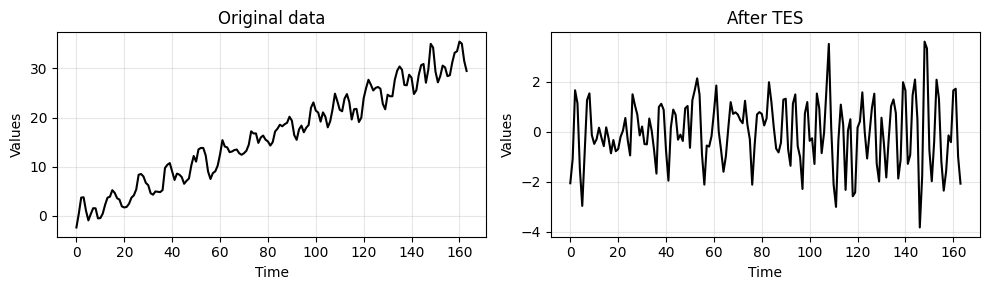

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, title="Original data", ax=ax[0])
run_sequence_plot(time[:len(train_data_ar)], tes_resid, title="After TES", ax=ax[1])
plt.tight_layout()

**💡 Подсказка**

- В этом случае мы знали, что основной период равен `12`.
- В общем случае нам нужно его оценить.
- Мы можем использовать функцию `fft_analysis`

In [25]:
from scipy.fft import fft
 
def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes

period, _, _ =fft_analysis(time_series_ar)
print(f"Period: {np.round(period)}")

Dominant Frequency: 0.085
Dominant Period: 11.76 time units
Period: 12.0


**⚠ Внимание**

- Сглаживатели работают здесь так хорошо, потому что мы используем игрушечные данные с аддитивными компонентами, линейным трендом, постоянной дисперсией и т. д.
- Многие реальные данные выглядят не так хорошо.
- В некоторых случаях нам приходится полагаться на другие методы, включая дифференциацию и график ACF/PACF

### Прогнозирование с помощью модели AR

- Как только данные станут стационарными, мы готовы подогнать модель AR(2).
- В зависимости от того, какой метод мы использовали для получения стационарных данных, мы должны сделать что-то другое, чтобы реконструировать прогнозы.
- Начнем со стационарных данных, полученных путем дифференцирования.

**Разностный подход**

- Сначала мы используем `diff_diff_ar` для подгонки модели AR(2) и делаем прогнозы на период, равный продолжительности тестовых данных.
- Обратите внимание, как через короткое время прогноз становится равным нулю.
- Это указывает на то, что модель AR(2) очень неопределенна в отношении долгосрочных прогнозов.

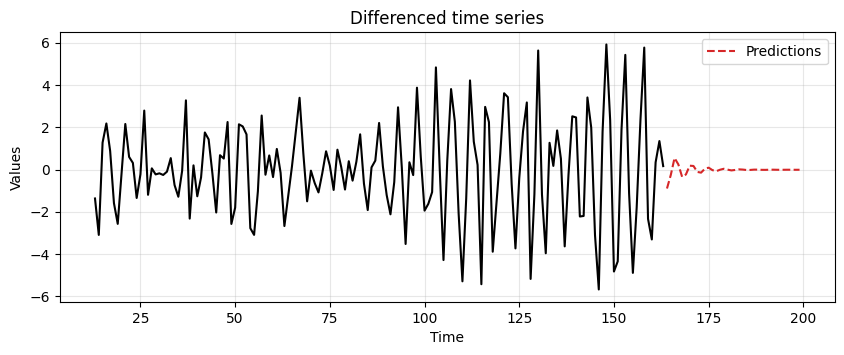

In [26]:
# Fit the model
model = ARIMA(diff_diff_ar, order=(2,0,0))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[13:len(train_data_ar)], diff_diff_ar, "")
ax.plot(time[len(train_data_ar):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- Для получения окончательных прогнозов мы должны сначала провести сезонную дифференциацию, а затем дифференциацию 1-го порядка по времени.

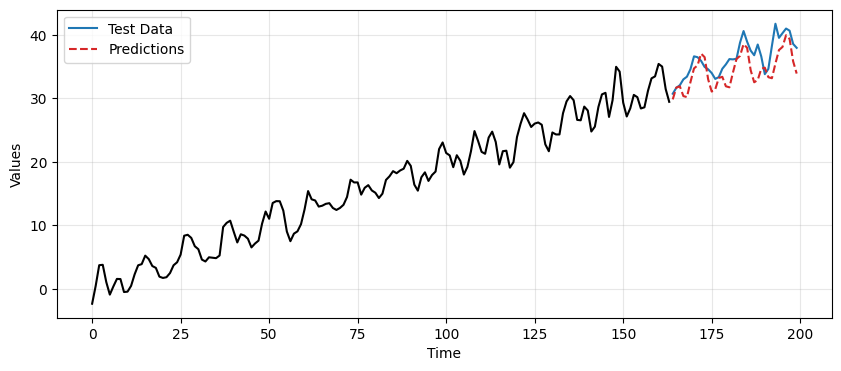

In [27]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ar))
reintegrated_seasonal[:12] = diff_ar[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ar)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ar[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**⚠ Внимание**

- Очень легко ошибиться с индексами при отмене операций дифференциации.
- Кроме того, предыдущие операции предполагают, что между обучающими и тестовыми данными нет пробелов.

**Подход на основе TES**

- Далее мы рассматриваем стационарные данные, полученные путем вычитания тренда и сезонности, оцененных с помощью TES.
- На этот раз мы используем `tes_resid` для подгонки модели AR(2) и составления прогнозов.

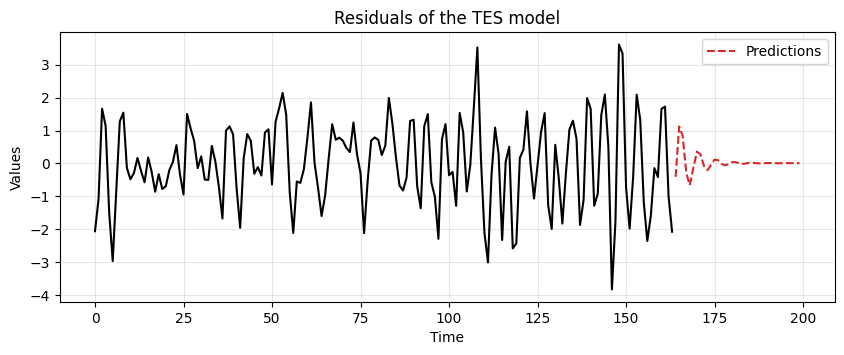

In [28]:
model = ARIMA(tes_resid, order=(2,0,0))
model_fit = model.fit()

resid_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[:len(train_data_ar)], tes_resid, "")
ax.plot(time[len(train_data_ar):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- Затем мы добавляем обратно тренд и сезонность к прогнозам.
- Для этого мы сначала генерируем прогнозы для трендовых и сезонных компонентов с помощью TES.
- Наконец, мы суммируем все прогнозы, чтобы получить окончательный результат.

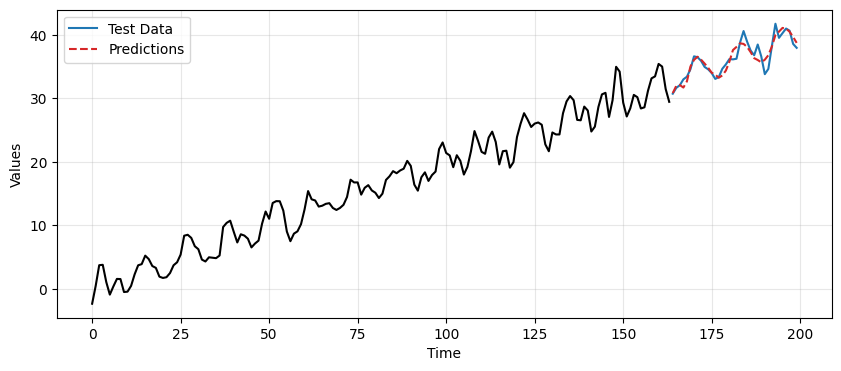

In [30]:
# Add back trend and seasonality to the predictions
tes_pred = tes.forecast(len(test_data_ar))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- В этом случае мы получаем лучшие прогнозы, используя подход на основе TES по сравнению с дифференцированием.
- Мы можем количественно оценить разницу в производительности, вычислив MSE.

In [32]:
mse_differencing = mean_squared_error(test_data_ar, reintegrated)
mse_tes = mean_squared_error(test_data_ar, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 7.16
MSE of TES: 1.11


---

## Moving Average (MA) models

- Другим подходом к моделированию одномерных временных рядов является модель скользящего среднего (MA).
- Модель MA представляет собой линейную регрессию текущего значения ряда против белого шума одного или нескольких предыдущих значений ряда.
- Предполагается, что шум в каждой точке исходит из нормального распределения со средним значением 0 и постоянной дисперсией.

- MA:

$$X(t) = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$$

- где:
    - $X(t)$: Time series value at time $t$.
    - $\mu$: Mean of the series.
    - $\theta_1, \theta_2, \dots, \theta_q$: Coefficients of the model.
    - $q$: Order of the MA model (number of lagged error terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

- Модели MA фиксируют зависимость между наблюдением и остаточной ошибкой посредством скользящего среднего, применяемого к запаздывающим наблюдениям.
- Подгонка оценок MA сложнее, чем у моделей AR, поскольку члены ошибки не наблюдаются.
- Поэтому необходимо использовать итерационные нелинейные процедуры подгонки.
- Модели MA менее интерпретируемы, чем модели AR.
- Как и модели AR, модели MA также требуют, чтобы данные были стационарными.

**⚠ Внимание**
- Мы говорили о сглаживании с помощью скользящих средних в Уроке 3.
- Модели MA не то же самое, что эти методы сглаживания.
- Каждая из них выполняет свою важную функцию.
- Мы не должны путать эти два понятия.

### Идентификация модели MA

- Раньше для [идентификации модели AR](#ar-model-identification) мы выбирали $p$ в качестве лага, после которого пики в PACF становятся незначимыми.
- Чтобы определить порядок $q$ модели MA, мы делаем то же самое, но вместо этого используем график ACF.
- Давайте рассмотрим это на примере.

- Мы генерируем некоторые данные из процесса MA(2) с коэффициентами `[1.0, 0.7, 0.8]`.
- Опять же, `1.0` в начале относится к нулевой задержке.

In [33]:
ma = np.array([1.0, 0.7, 0.8])  # MA parameters
ma_data = arma_generate_sample(np.array([1]), ma, nsample=len(time), scale=1, burnin=1000) # MA process

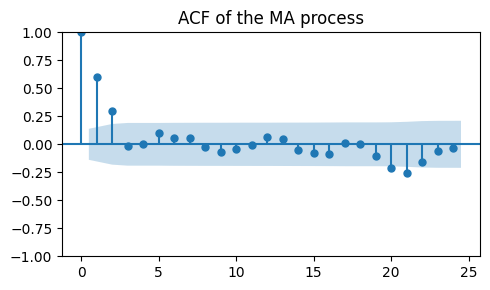

In [34]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ma_data, ax=ax, title="ACF of the MA process")
plt.tight_layout();

- Как и ожидалось, после второго лага происходит отсечка.
- Это указывает на то, что порядок модели MA равен $q=2$.

- Характерными для процесса MA являются медленно затухающие, альтернативные пики на графике PACF.
- Обратите внимание, как это дополняет то, что мы видели для [процесса AR](#ar-model-identification).

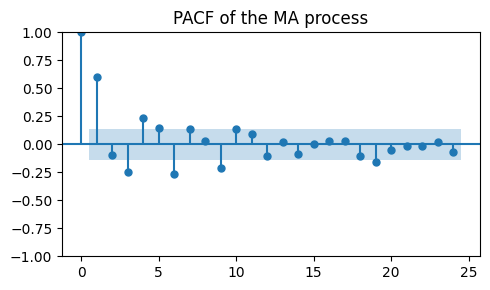

In [35]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(ma_data, ax=ax, title="PACF of the MA process")
plt.tight_layout();

**⚙ Попробуйте сами**

- Попробуйте изменить/добавить/удалить значения в коэффициентах `ma` в `arma_generate_sample`.
- Затем посмотрите, как изменится график ACF.

### Пример: прогнозирование с помощью модели MA

- Мы повторяем ту же процедуру, что и в [примере AR](#example-forecasting-with-ar-model) с моделью MA.
- Единственное отличие в том, что теперь мы строим временной ряд с помощью процесса MA, а не AR.

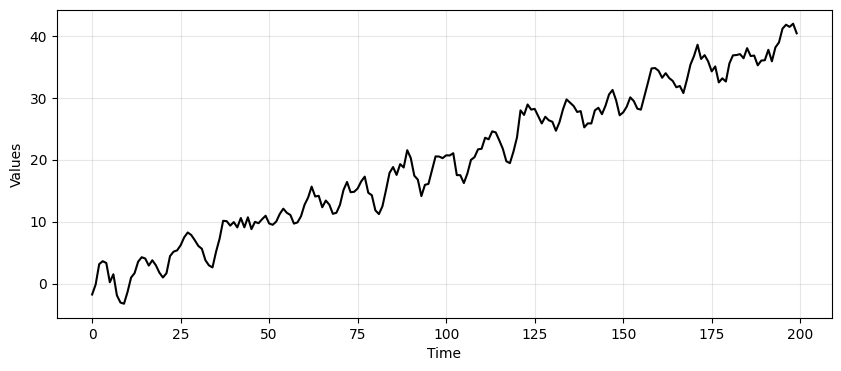

In [36]:
time_series_ma = trend + seasonality + ma_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ma, "", ax=ax);

In [37]:
# Train/test split
train_data_ma = time_series_ma[:164]
test_data_ma = time_series_ma[164:]

- To identify the order $q$ of the MA model we must look at the ACF plot.
- Let's start by computing the ACF of `train_data_ma`, which looks very different from the ACF plot we obtained [before](#ma-model-identification) for the MA process.

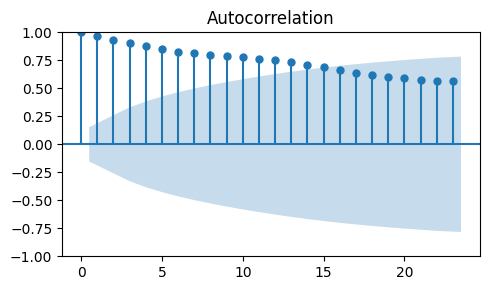

In [38]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(train_data_ma, ax=ax)
plt.tight_layout();

- Также в этом случае нам необходимо сделать временной ряд стационарным, чтобы получить осмысленный график ACF.
- Как и в случае AR, стационарность необходима для правильной оценки коэффициентов MA.

#### Стационарность через дифференциацию

- Как и в примере с AR, мы попытаемся получить стационарность через дифференциацию.

In [39]:
diff_ma = train_data_ma[1:] - train_data_ma[:-1]

- Чтобы убедиться, что наши данные стационарны, мы вычисляем тест ADF до и после дифференциации.

In [40]:
_, pvalue_ts, _, _, _, _ = adfuller(train_data_ma)
_, pvalue_diff, _, _, _, _ = adfuller(diff_ma)
print(f"p-value (original ts): {pvalue_ts:.3f}")
print(f"p-value (differenced ts): {pvalue_diff:.3f}")

p-value (original ts): 0.925
p-value (differenced ts): 0.000


- Мы также наносим на график данные после дифференцирования и вычисляем ACF.

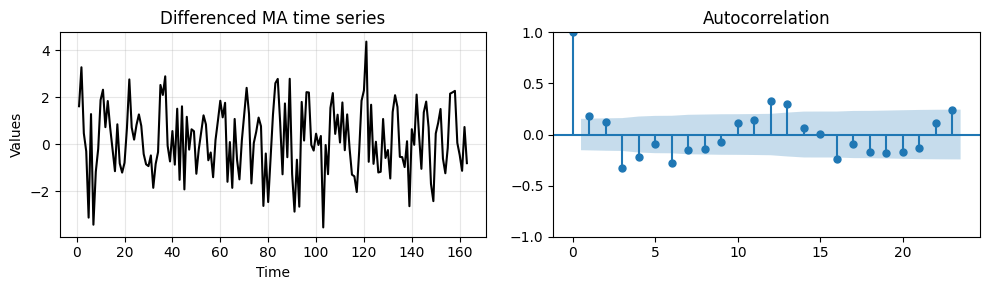

In [41]:
_, axes = plt.subplots(1,2, figsize=(10, 3))
run_sequence_plot(time[1:len(train_data_ma)], diff_ma, "Differenced MA time series", ax=axes[0])
plot_acf(diff_ma, ax=axes[1])
plt.tight_layout();

- Как и в предыдущем случае, у нас есть значимые корреляции при более высоких лагах из-за сезонной составляющей.
- Для сравнения мы вычисляем ACF:
    - исходного процесса MA,
    - временного ряда после дифференциации 1-го порядка,
    - временного ряда с дифференциацией 1-го порядка и сезонной дифференциацией.

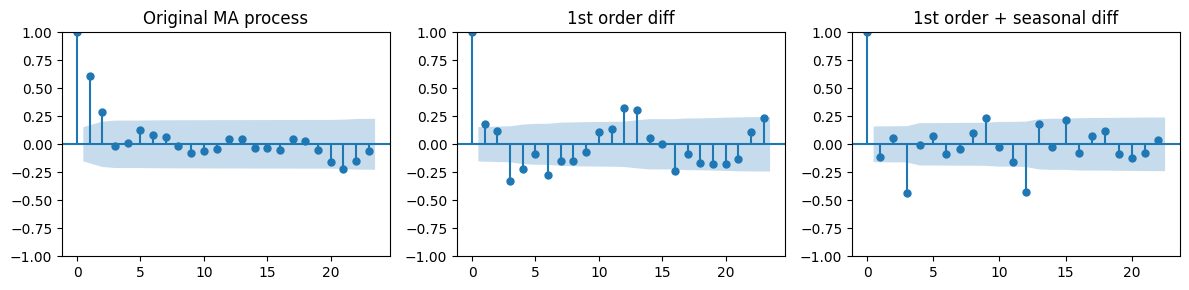

In [42]:
diff_diff_ma = diff_ma[12:] - diff_ma[:-12]

_, axes = plt.subplots(1,3, figsize=(12, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="Original MA process")
plot_acf(diff_ma, ax=axes[1], title="1st order diff")
plot_acf(diff_diff_ma, ax=axes[2], title="1st order + seasonal diff")
plt.tight_layout();

- При выполнении обоих дифференцирований график ACF выглядит совершенно по-разному.
- Положительные корреляции на лагах 1 и 2 исчезли, а первая ненулевая корреляция появляется на лаге 3.
- Как мы видели в случае AR, это намекает на сверхдифференциацию.

- В заключение, не очевидно, какую модель MA использовать из анализа графиков ACF.
- ACF после дифференцирования 1-го порядка предполагает использование порядка $q=1$ или $q=2$.
- ACF, полученный после сезонного дифференцирования, предполагает порядок $q=3$, но мы подозреваем чрезмерное дифференцирование.

#### Стационарность путем вычитания оцененного тренда и сезонности

- Далее мы повторяем ту же процедуру для оценки тренда и сезонности с помощью TES.
- Поскольку процесс MA более «шумный», чем процесс AR, мы увеличиваем уровень сглаживания, устанавливая $\alpha=0.01$.
- Как показано на графике ниже, это приводит к более плавной оценке тренда и сезонности.

Dominant Frequency: 0.085
Dominant Period: 11.76 time units


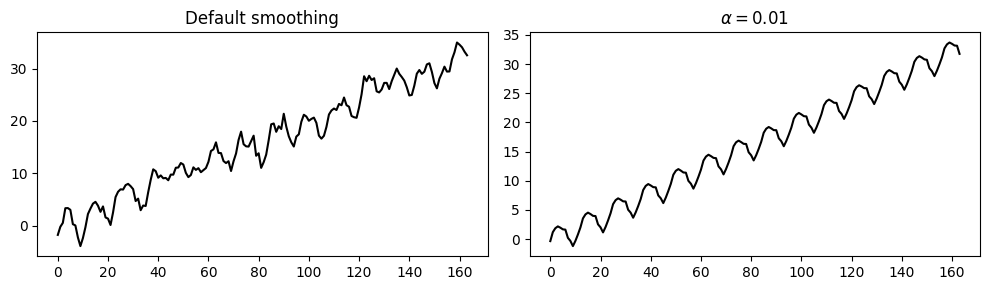

In [43]:
period, _, _ =fft_analysis(time_series_ma)
period = np.round(period).astype(int)

tes_ma_default = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=None)
tes_ma = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=0.01)
trend_and_seasonality_default = tes_ma_default.fittedvalues
trend_and_seasonality = tes_ma.fittedvalues

_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(trend_and_seasonality_default, 'k')
axes[0].set_title('Default smoothing')
axes[1].plot(trend_and_seasonality, 'k')
axes[1].set_title('$\\alpha=0.01$')
plt.tight_layout();

- Далее мы вычисляем остатки, вычитая предполагаемый тренд и сезонность.
- Графики ACF исходного процесса MA и остатков очень похожи.
- Это указывает на то, что мы правильно удалили тренд и сезонность.

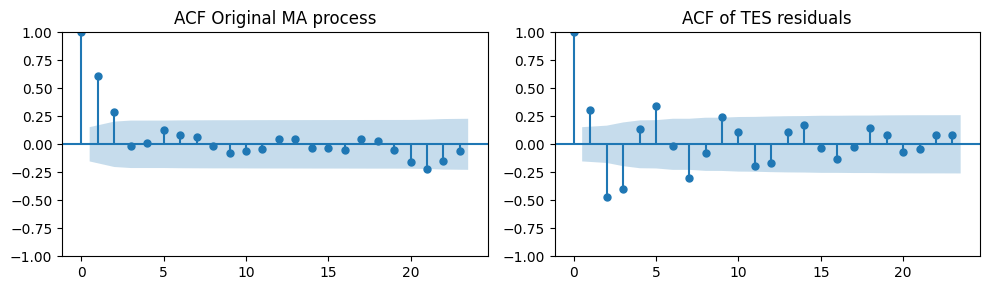

In [44]:
tes_resid_ma = train_data_ma - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="ACF Original MA process")
plot_acf(tes_resid, ax=axes[1], title="ACF of TES residuals")
plt.tight_layout();

- График ACF показывает значительный всплеск на лаге 3.
- Это предполагает использование модели MA с порядком $q=3$.
- Как и в случае AR, мы вычисляем прогнозы, используя как подход на основе разности, так и подход на основе TES.

**Подход к дифференцированию**

- Мы начинаем с подгонки модели MA к данным `diff_diff_ma` и вычисления прогнозов.
- Обратите внимание, что даже если мы сгенерировали данные с помощью процесса MA(2), мы используем процесс MA(3), поскольку ACF `diff_diff_ma` имела большой всплеск на лаге 3.

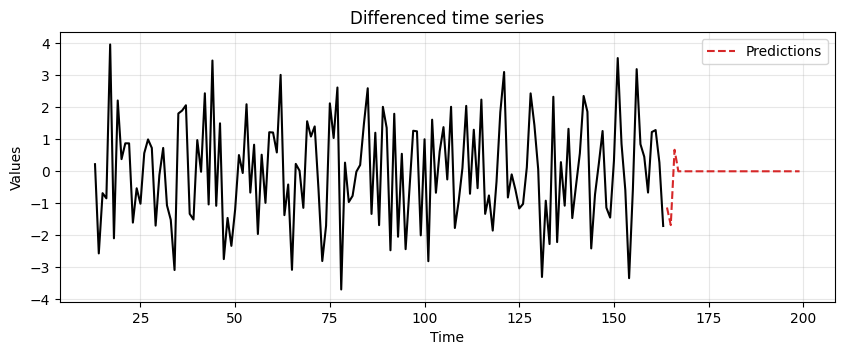

In [45]:
# Fit the model
model = ARIMA(diff_diff_ma, order=(0,0,3))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ma))

ax = run_sequence_plot(time[13:len(train_data_ma)], diff_diff_ma, "")
ax.plot(time[len(train_data_ma):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- Затем мы повторяем две операции разности, чтобы получить окончательные прогнозы.

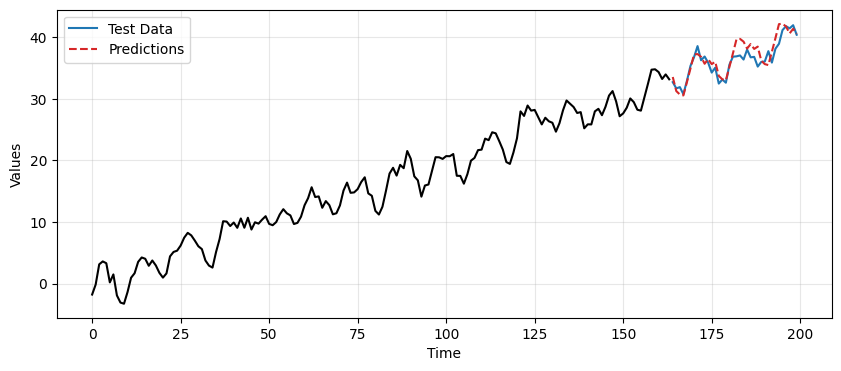

In [46]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ma))
reintegrated_seasonal[:12] = diff_ma[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ma)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ma[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**Подход на основе TES**

- На этот раз мы подгоняем модель MA под данные `tes_resid_ma` и вычисляем прогнозы.
- Обратите внимание, что мы снова используем модель MA(3), хотя знаем, что данные были получены в результате процесса MA(2).

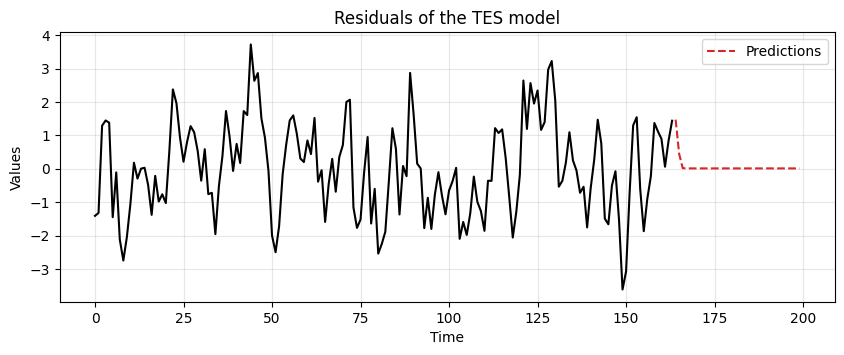

In [47]:
model = ARIMA(tes_resid_ma, order=(0,0,3))
model_fit = model.fit() # Fit the model

resid_preds = model_fit.forecast(steps=len(test_data_ma)) # Compute predictions

ax = run_sequence_plot(time[:len(train_data_ma)], tes_resid_ma, "")
ax.plot(time[len(train_data_ma):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- Окончательные прогнозы получаются путем объединения:
    - прогнозов остатков из модели MA,
    - прогноза тренда и сезонности из модели TES.

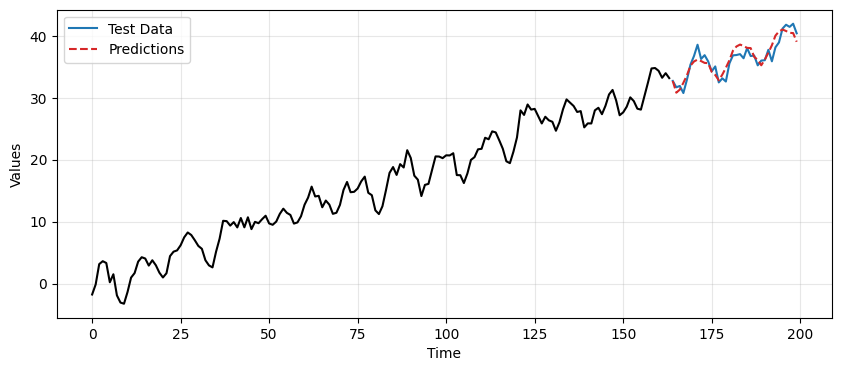

In [48]:
# Add back trend and seasonality to the predictions
tes_pred = tes_ma.forecast(len(test_data_ma))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- На этот раз разностный подход дает лучшие результаты, но все еще хуже, чем подход на основе TES.

In [49]:
mse_differencing = mean_squared_error(test_data_ma, reintegrated)
mse_tes = mean_squared_error(test_data_ma, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 2.09
MSE of TES: 1.44


---

## Резюме

### Модели AR и MA

| **Модели AR** | **Модели MA** |
|:-------------|:---------------|
|Зависят от прошлых значений ряда. | Зависят от прошлых ошибок прогноза. |
| Подходит, когда прошлые значения оказывают прямое влияние на будущие значения и для медленно меняющихся временных рядов | Полезно, когда ряд лучше объясняется шоками или случайными возмущениями, т. е. временными рядами с внезапными изменениями|
| Если **PACF** резко падает при заданном лаге $p$, то используйте модель **AR** с порядком $p$| Если **ACF** резко падает при заданном лаге $q$, то используйте модель **MA** с порядком $q$ |

В этой лекции вы должны были изучить основы:

1. Автокорреляционная функция (ACF).
2. Частичная автокорреляционная функция (PACF).
3. Авторегрессионные (AR) модели.
4. Выбор порядка $p$.
5. Модели скользящего среднего (MA).
6. Выбор порядка $q$.
7. Объединение сглаживателей для прогнозирования тренда и сезонности с моделями AR/MA для прогнозирования остатков.

## Упражнения

- Загрузите два временных ряда `arma_ts1` и `arma_ts2`, выполнив код ниже.

479
1000


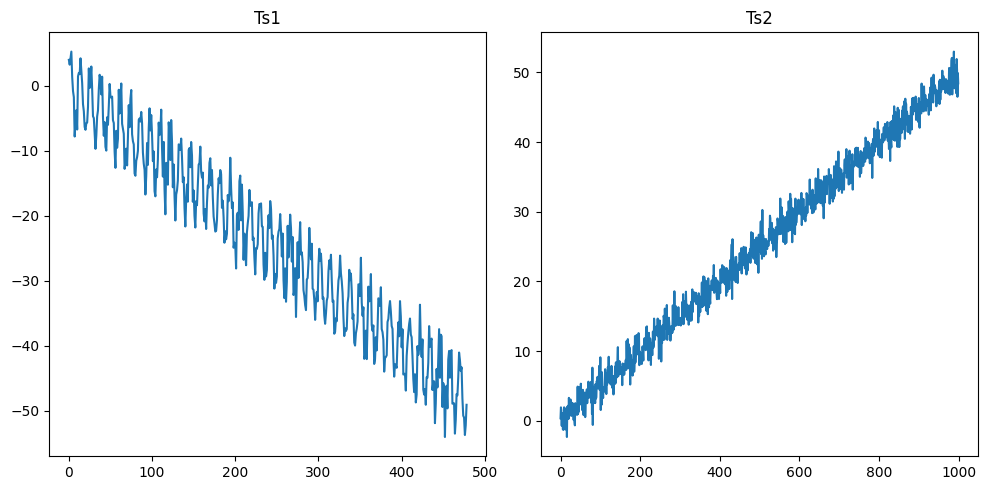

In [3]:

from io import BytesIO
import numpy as np
import requests


response = requests.get("https://zenodo.org/records/10951538/files/arma_ts3.npz?download=1") 
response.raise_for_status() 
ts1 = np.load(BytesIO(response.content))['signal']
print(len(ts1))

response = requests.get("https://zenodo.org/records/10951538/files/arma_ts4.npz?download=1") 
response.raise_for_status() 
ts2 = np.load(BytesIO(response.content))['signal']
print(len(ts2))

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ts1)
plt.title("Ts1")
plt.subplot(1,2,2)
plt.plot(ts2)
plt.title("Ts2")
plt.tight_layout()

Для каждого временного ряда:

1. Разделите временной ряд на обучающий и тестовый.
    - Используйте последние 30 значений в качестве тестовых для первого временного ряда.
    - Используйте последние 100 значений в качестве тестовых для второго временного ряда.
2. Сделайте временной ряд стационарным.
3. Определите порядок $p$ модели AR.
4. Вычислите прогноз тестовых данных с помощью модели AR($p$).
5. Определите порядок $q$ модели MA.
6. Вычислите прогноз тестовых данных с помощью модели MA($q$).

Text(0.5, 1.0, 'ts2 diff')

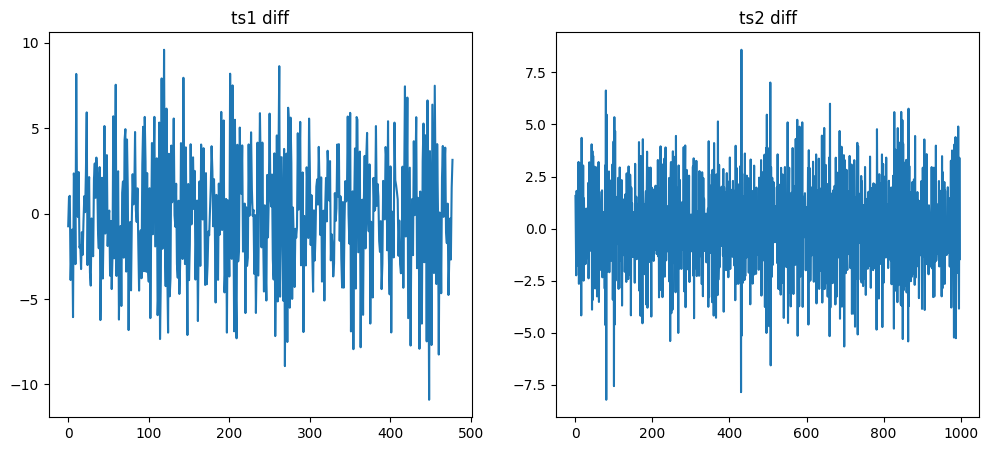

In [4]:
ts1_diff = np.diff(ts1)
ts2_diff = np.diff(ts2)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(ts1_diff)
plt.title("ts1 diff")
plt.subplot(1,2,2)
plt.plot(ts2_diff)
plt.title("ts2 diff")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf

def plot_ar_order_determination(data, lags=40, series_name="Time Series Data"):

    
    if isinstance(data, np.ndarray):
        data = pd.Series(data)
        
  
    stationary_data = data.diff().dropna()

    plt.figure(figsize=(15, 5))
    plot_pacf(stationary_data, lags=lags, method='ols', title=f'Partial Autocorrelation Function (PACF) for {series_name}')
    
    plt.xlabel('Lags (p)')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True, alpha=0.3)
    plt.show()

<Figure size 1500x500 with 0 Axes>

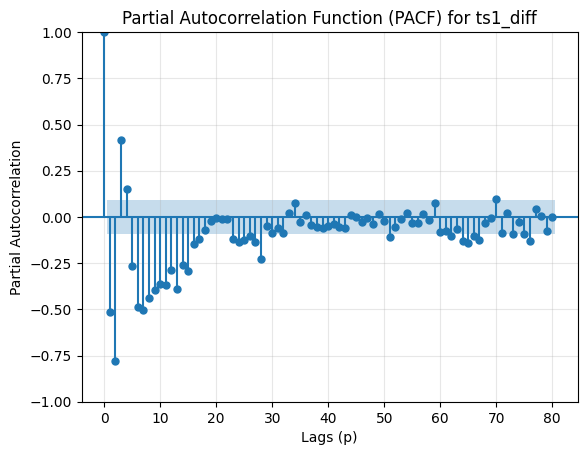

<Figure size 1500x500 with 0 Axes>

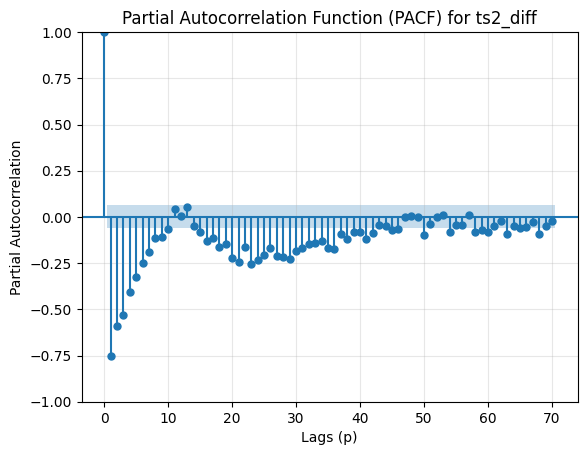

In [6]:
plot_ar_order_determination(ts1_diff, lags=80, series_name="ts1_diff")
plot_ar_order_determination(ts2_diff, lags=70, series_name="ts2_diff")

--- Результаты прогноза ---
Mean Squared Error (MSE): **5.1262**


c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


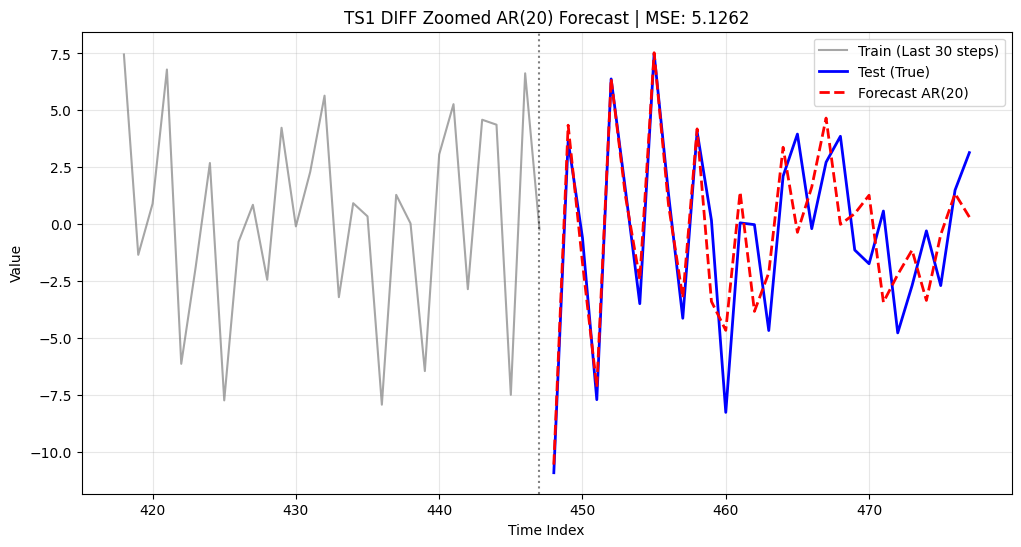

c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


--- Результаты прогноза ---
Mean Squared Error (MSE): **8.1276**


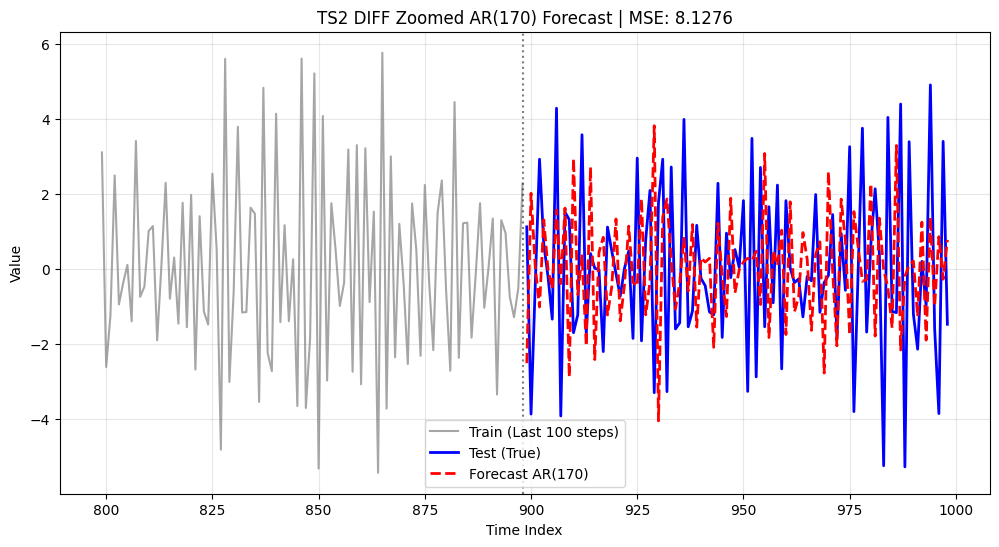

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
def forecast_ar_model_with_plot(train: np.ndarray, test: np.ndarray, p_lags: int,title=""):
    if not isinstance(train, pd.Series):
        train = pd.Series(train)
        
    train_stationary = train.diff().dropna()
    N = len(train)
    K = len(test)
    
    model = AutoReg(train_stationary, lags=p_lags, seasonal=False, old_names=False)
    model_fit = model.fit()
    
  
    start_index = len(train_stationary)
    end_index = start_index + K - 1
    forecast_stationary = model_fit.predict(start=start_index, end=end_index)

    last_train_value = train.iloc[-1]
    forecast_original_scale = last_train_value + np.cumsum(forecast_stationary.values)


    mse = mean_squared_error(test, forecast_original_scale)
    print(f"--- Результаты прогноза ---")
    print(f"Mean Squared Error (MSE): **{mse:.4f}**")
    
  
    plt.figure(figsize=(12, 6))
    
    
    train_slice_idx = np.arange(N - K, N)
    test_slice_idx = np.arange(N, N + K)

   
    plt.plot(train_slice_idx, train.iloc[-K:], label=f'Train (Last {K} steps)', color='gray', alpha=0.7)
    

    plt.plot(test_slice_idx, test, label='Test (True)', color='blue', lw=2)
    plt.plot(test_slice_idx, forecast_original_scale, label=f'Forecast AR({p_lags})', color='red', linestyle='--', lw=2)
    

    plt.axvline(x=N-1, color='black', linestyle=':', alpha=0.5) # Divider line
    plt.title(title+f" Zoomed AR({p_lags}) Forecast | MSE: {mse:.4f}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return forecast_original_scale

predicted_values_ar = forecast_ar_model_with_plot(
    train=ts1_diff[:-30], 
    test=ts1_diff[-30:], 
    p_lags=20,
    title="TS1 DIFF"
)

predicted_values_ar = forecast_ar_model_with_plot(
    train=ts2_diff[:-100], 
    test=ts2_diff[-100:], 
    p_lags=170,
    title="TS2 DIFF"
)

c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarnin

--- Результаты MA(20) ---
MSE: **7.5231**


c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


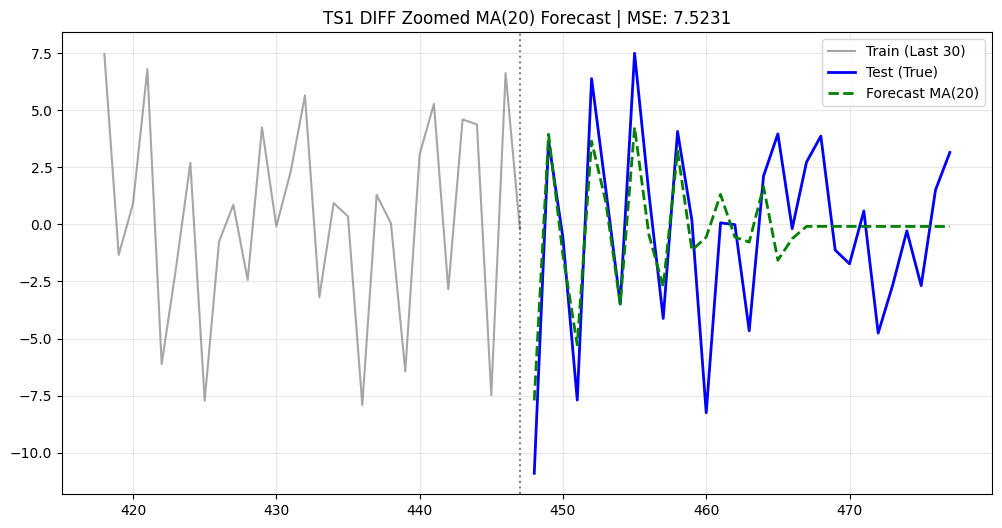

c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarnin

--- Результаты MA(40) ---
MSE: **4.9731**


c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\A1ex5\Desktop\CodeFlow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


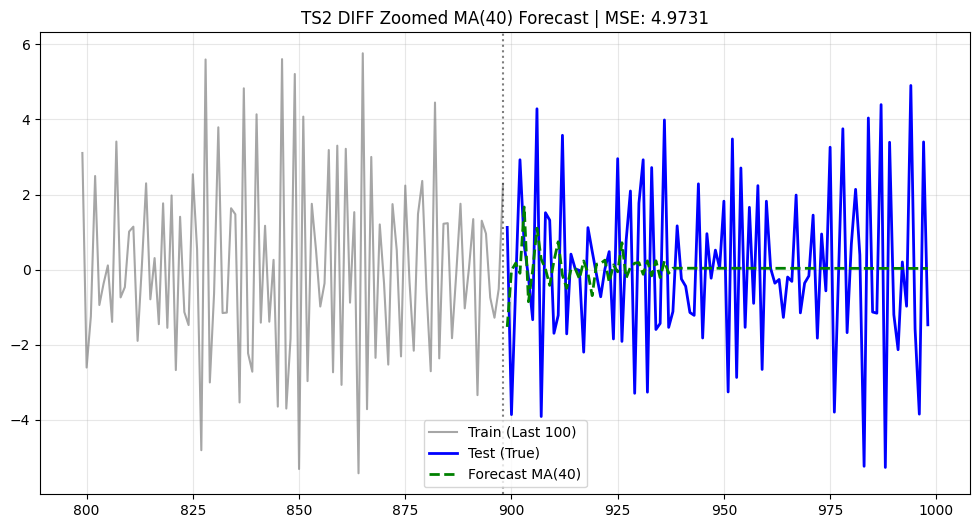

In [8]:
from statsmodels.tsa.arima.model import ARIMA
def forecast_ma_model_with_plot(train: np.ndarray, test: np.ndarray, q_lags: int, title=""):
  
    if not isinstance(train, pd.Series):
        train = pd.Series(train)
        
    train_stationary = train.diff().dropna()
    N, K = len(train), len(test)

    model = ARIMA(train_stationary, order=(0, 0, q_lags))
    model_fit = model.fit()
    
    
    forecast_stationary = model_fit.forecast(steps=K)
    
   
    last_train_value = train.iloc[-1]
    forecast_original_scale = last_train_value + np.cumsum(forecast_stationary)

   
    mse = mean_squared_error(test, forecast_original_scale)
    print(f"--- Результаты MA({q_lags}) ---")
    print(f"MSE: **{mse:.4f}**")
    
    
    plt.figure(figsize=(12, 6))
    train_slice_idx = np.arange(N - K, N)
    test_slice_idx = np.arange(N, N + K)

    plt.plot(train_slice_idx, train.iloc[-K:], label=f'Train (Last {K})', color='gray', alpha=0.7)
    plt.plot(test_slice_idx, test, label='Test (True)', color='blue', lw=2)
    plt.plot(test_slice_idx, forecast_original_scale, label=f'Forecast MA({q_lags})', color='green', linestyle='--', lw=2)
    
    plt.axvline(x=N-1, color='black', linestyle=':', alpha=0.5)
    plt.title(f"{title} Zoomed MA({q_lags}) Forecast | MSE: {mse:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return forecast_original_scale


predicted_values_ar = forecast_ma_model_with_plot(
    train=ts1_diff[:-30], 
    test=ts1_diff[-30:], 
    q_lags=20,
    title="TS1 DIFF"
)


predicted_values_ar = forecast_ma_model_with_plot(
    train=ts2_diff[:-100], 
    test=ts2_diff[-100:], 
    q_lags=40,
    title="TS2 DIFF"
)